# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
## Programación Distribuida sobre Grandes Volúmenes de Datos

Damián Barsotti 

### Facultad de Matemática Astronomía Física y Computación
## Universidad Nacional de Córdoba

<img src="http://program.ar/wp-content/uploads/2018/07/logo-UNC-FAMAF.png" alt="Drawing" style="width:80%;"/>

### Transformer

* Toma un `DataFrame` y devuelven un `DataFrame` transformado.
    - método `transform(<DataFrame>)`
* Ejemplos:
    - Transformador de features

        %%% yuml type=class style=plain format=svg
          [note:Dataframe;Entrada{bg:cornsilk}]->[Transformer;(featurizer)|transform(){bg:orange}]
          [Transformer;(featurizer)|transform(){bg:orange}]->[note:Dataframe; features{bg:cornsilk}]
        %%%

    - Modelo

        %%% yuml type=class style=plain format=svg
          [note:Dataframe; features{bg:cornsilk}]->[Transformer;(modelo)|transform(){bg:orange}]
          [Transformer;(modelo)|transform(){bg:orange}]->[note:Dataframe; predicción{bg:cornsilk}]
        %%%


### Estimator

* Encapsula un algoritmo ML.
* Toma un `DataFrame` de entrenamiento y devuelve un `Transformer`
    - método `fit(<DataFrame>)`

      %%% yuml type=class style=plain format=svg
         [note:Dataframe; features;(entrenamiento){bg:cornsilk}]->[Estimator;(algoritmo ML)|fit()]
         [Estimator;(algoritmo ML)|fit(){bg:red}]->[note:Transformer;(modelo){bg:orange}]
      %%%

* Ejemplos:
    - Logistic Regression

Veamos el siguiente ejemplo con un flujo de trabajo ML clásico.

In [1]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("06_ml_pipelines").getOrCreate()
sc = spark.sparkContext

### Datos de entrenamiento

In [4]:
training = spark.createDataFrame([
        (0, "a b c d e spark a", 1.0),
        (1, "b d", 0.0),
        (2, "spark f g h", 1.0),
        (3, "hadoop a mapreduce", 0.0)
    ], ["id", "text", "label"])

In [5]:
training.show()

+---+------------------+-----+
| id|              text|label|
+---+------------------+-----+
|  0| a b c d e spark a|  1.0|
|  1|               b d|  0.0|
|  2|       spark f g h|  1.0|
|  3|hadoop a mapreduce|  0.0|
+---+------------------+-----+



### Featurization
#### Tokenizer

In [6]:
from pyspark.ml.feature import HashingTF, Tokenizer

# Creo Tokenizer Transformer
tokenizer = Tokenizer(
    inputCol="text",
    outputCol="words")

# Aplico la transformación devolviendo un nuevo dataframe
tokenizerOut = tokenizer.transform(training)

tokenizerOut.show()

+---+------------------+-----+--------------------+
| id|              text|label|               words|
+---+------------------+-----+--------------------+
|  0| a b c d e spark a|  1.0|[a, b, c, d, e, s...|
|  1|               b d|  0.0|              [b, d]|
|  2|       spark f g h|  1.0|    [spark, f, g, h]|
|  3|hadoop a mapreduce|  0.0|[hadoop, a, mapre...|
+---+------------------+-----+--------------------+



#### Feature Vector

In [7]:
# Creo un Term Frecuency Transformer con hash
hashingTF = HashingTF(
    numFeatures=1000,
    inputCol = tokenizer.getOutputCol(), 
    outputCol="features")

# Aplico la transformación al resultado de la transformación previa
hashingTFOut = hashingTF.transform(tokenizerOut)

hashingTFOut.printSchema() 
# Notar tipo de la columna "features"
# El primer elemento de la tupla es el tamaño

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



In [8]:
hashingTFOut.show()

+---+------------------+-----+--------------------+--------------------+
| id|              text|label|               words|            features|
+---+------------------+-----+--------------------+--------------------+
|  0| a b c d e spark a|  1.0|[a, b, c, d, e, s...|(1000,[165,286,46...|
|  1|               b d|  0.0|              [b, d]|(1000,[165,890],[...|
|  2|       spark f g h|  1.0|    [spark, f, g, h]|(1000,[286,486,49...|
|  3|hadoop a mapreduce|  0.0|[hadoop, a, mapre...|(1000,[467,585,75...|
+---+------------------+-----+--------------------+--------------------+



### Modelo
#### Creacion

In [9]:
from pyspark.ml.classification import LogisticRegression

# Creo el Estimator
lr = LogisticRegression(
    maxIter=10,
    regParam=0.01)
  
# Entreno el Estimador obteniendo un modelo
model = lr.fit(hashingTFOut)

#### Predicción

In [10]:
# Creo un DF para testearel modelo
test = spark.createDataFrame([
  (4, "spark i j k a"),
  (5, "l m n"),
  (6, "mapreduce spark"),
  (7, "apache hadoop"),
  (8, "spark f j k")
], ["id", "text"])


# Featurizo el test
testTokens = tokenizer.transform(test)

testFeatures = hashingTF.transform(testTokens)

predictions = model.transform(testFeatures)

predictions.select("id", "text", "probability", "prediction").show()

+---+---------------+--------------------+----------+
| id|           text|         probability|prediction|
+---+---------------+--------------------+----------+
|  4|  spark i j k a|[0.41787088770315...|       1.0|
|  5|          l m n|[0.95412623885153...|       0.0|
|  6|mapreduce spark|[0.83657689444954...|       0.0|
|  7|  apache hadoop|[0.98578644499166...|       0.0|
|  8|    spark f j k|[0.25910961733038...|       1.0|
+---+---------------+--------------------+----------+



## Pipelines
---

* Abstracción del flujo de trabajo en ML:

      %%% yuml style=plain scale=80 dir=LR format=svg
        [Featurization]->[Entrenamiento]
        [Entrenamiento]->[Modelo]
        [Modelo]->[Predicción]
        [Modelo]->[Evaluación]
      %%%

* Para su construcción se usan **Transformers** y **Estimators** (llamados Stages)
    - los concatena

* Un pipeline es un **Estimator**
    - método `fit(<DataFramee>)` devuelve un `PipelineModel` (Transformer)

In [11]:
from pyspark.ml import Pipeline

# Creo el pipeline con los Transformers y el Estimator
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Con fit el pipeline genera los fetures y entrena.
pipModel = pipeline.fit(training)


### Pipeline de entrenamiento

<img     src="https://bitbucket.org/bigdata_famaf/diplodatos_bigdata/raw/b17129f7118b3389b8c7f2f85fd89c6238fe0edd/clases/06_ml_pipelines/ml-Pipeline.png" alt="Drawing" style="width:80%;"/>

### PipelineModel

* El resultado anterior es un modelo (Transformer) que se puede usar para predecir
    - método `transform(<DataFrame>)`
* Usa los mismos Transformers de *featurizacion* que para el entrenamiento
    - ahorra código

In [12]:
# El modelo en el pipeline solo necesita el Raw Test:
# automaticamente aplica los transformadores de features
# y hace predicciones.

predictions = pipModel.transform(test)

predictions.select("id", "text", "probability", "prediction").show()

+---+---------------+--------------------+----------+
| id|           text|         probability|prediction|
+---+---------------+--------------------+----------+
|  4|  spark i j k a|[0.41787088770315...|       1.0|
|  5|          l m n|[0.95412623885153...|       0.0|
|  6|mapreduce spark|[0.83657689444953...|       0.0|
|  7|  apache hadoop|[0.98578644499166...|       0.0|
|  8|    spark f j k|[0.25910961733038...|       1.0|
+---+---------------+--------------------+----------+



### Persistencia

In [13]:
from pyspark.ml import PipelineModel

# El pipeline entrenado se puede guardar
pipModel.write().overwrite().save("../outpus/spark-logistic-regression-model")

# Y cargarlo para la etapa de uso
samePipModel = PipelineModel.load("../outpus/spark-logistic-regression-model")

# Tambien el pipeline sin entrenar
pipeline.write().overwrite().save("../outpus/unfit-lr-model")

In [14]:
!ls ../outpus/spark-logistic-regression-model

metadata  stages


### Ejercicio

Hacer con pipelines uno de los ejemplos de clasificacionde clase anterior. Plotear el resultado.


1. Cargo DataSet

In [15]:
inputFile = "../inputs/ds/people_sex_height_age_weight.json"

people = spark.read.json(inputFile) \
    .select("kgs", "mts", "sex") \
    .repartition(sc.defaultParallelism) \
    .cache()
    
print("Cantidad de filas: {}. Cantidad de particiones: {}.".format(people.count(), people.rdd.getNumPartitions()))

people.sample(False,0.001).show()

Cantidad de filas: 10000. Cantidad de particiones: 20.
+------------------+------------------+---+
|               kgs|               mts|sex|
+------------------+------------------+---+
| 72.81831643645533|1.7544597654491818|  M|
|60.949928625438524|1.6975623807791556|  F|
| 70.24333971385092|1.8259276588557454|  F|
| 67.62067887632992|1.7804981862855906|  M|
| 61.29672592416653|1.6632101052103694|  F|
| 72.08259574539099|1.7671867744768517|  M|
| 63.45106152045664|1.6891196912430215|  F|
| 60.85591058807166|1.6966526825991124|  F|
|   72.151926754284|1.8599631914042996|  M|
| 77.57259751121087|1.7969945445414748|  M|
|104.49953850078195|1.7135897374401317|  F|
| 90.37376585473201|1.7672043589102346|  F|
| 72.35400800545294| 1.780606924549926|  M|
+------------------+------------------+---+



2. Split DataSet

In [16]:
trainDF, testDF = people.randomSplit([0.95, 0.05]) 

print(testDF.count(), trainDF.count())

506 9494


3. VectorAssembler

In [17]:
from pyspark.ml.feature import VectorAssembler

vAssembler = VectorAssembler(
    inputCols=["kgs", "mts"],
    outputCol="features")

4. StringIndexer

In [18]:
from pyspark.ml.feature import StringIndexer

strIndexer = StringIndexer(
  inputCol="sex",
  outputCol="label")

5. PolynomialExpansion

In [19]:
from pyspark.ml.feature import PolynomialExpansion

polyExpansion = PolynomialExpansion( 
    inputCol="features",
    outputCol="features_expansion",
    degree=3) # llenar (ver documentacion)

#### Creacion del `Pipeline`

In [32]:
# Creo el pipeline con los Transformers y el Estimator
pipaline = Pipeline(
    stages=[vAssembler, strIndexer, polyExpansion])

# Con fit el pipeline genera los fetures y entrena.
prePro = pipaline.fit(trainDF)
pipaPre = prePro.transform(trainDF)
#model = lrEstimatorPoly.fit(pipaPre)
pipaPre.show()

+--------------------+------------------+---+--------------------+-----+--------------------+
|                 kgs|               mts|sex|            features|label|  features_expansion|
+--------------------+------------------+---+--------------------+-----+--------------------+
|-0.02439943239118...| 1.803802100446955|  F|[-0.0243994323911...|  1.0|[-0.0243994323911...|
|  0.6291486615052309| 1.630190117559786|  F|[0.62914866150523...|  1.0|[0.62914866150523...|
|   10.86790156913123| 1.852049089564589|  F|[10.8679015691312...|  1.0|[10.8679015691312...|
|   38.11229329793476|1.5357829370692366|  F|[38.1122932979347...|  1.0|[38.1122932979347...|
|   44.87858730352653|1.6775557703865216|  F|[44.8785873035265...|  1.0|[44.8785873035265...|
|  45.277876012770996|1.7240233052200462|  F|[45.2778760127709...|  1.0|[45.2778760127709...|
|   45.32435551005798| 1.594819377273792|  F|[45.3243555100579...|  1.0|[45.3243555100579...|
|  45.430791163886475|1.6113765748371114|  F|[45.43079116388

6. LogisticRegression

In [28]:
lrEstimatorPoly = LogisticRegression(
    featuresCol="features_expansion", # llenar
    maxIter=100,
    regParam=0.01)

lrModelPoly = lrEstimatorPoly.fit(pipaPre) # llenar

Grilla para test

In [30]:
def createGrid():

    from pyspark.sql.functions import min, max
    
    maxTics = 256

    def fgrid (x, min, max, tics):
        tics2 = tics - 2
        return (float(x-1)*(max-min)+tics2*min)/tics2


    minKgs, maxKgs, minMts, maxMts = people.agg(min("kgs"), max("kgs"), min("mts"), max("mts")).first()

    # 1.- numeracion ticks en x 
    # 2.- numeracion ticks en (x, y)
    # 3.- todos los (kgs, mts) 
    return sc.parallelize(range(maxTics)) \
            .flatMap(lambda x: [ (x, y) for y in range(maxTics)]) \
            .map(lambda x_y: (fgrid(x_y[0], minKgs, maxKgs, maxTics), fgrid(x_y[1], minMts, maxMts, maxTics))) \
            .toDF(["kgs", "mts"])


In [33]:
gridPoly = prePro.transform(createGrid()).cache()
gridPoly.limit(5).show()

+-------------------+------------------+--------------------+--------------------+
|                kgs|               mts|            features|  features_expansion|
+-------------------+------------------+--------------------+--------------------+
|-0.5960327326330384| 1.121333932803231|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384|1.1255756685431166|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384| 1.129817404283002|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384|1.1340591400228877|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384| 1.138300875762773|[-0.5960327326330...|[-0.5960327326330...|
+-------------------+------------------+--------------------+--------------------+



In [38]:
gridPredictionLRPoly = lrModelPoly.transform(gridPoly)
                            
gridPredictionLRPoly.sample(False,0.001).toPandas().head(5)

,kgs,mts,features,features_expansion,rawPrediction,probability,prediction
0,0.547234,1.621859,"[0.5472338678506727, 1.6218587501097188]","[0.5472338678506727, 0.2994649061228076, 0.163...","[-5.909464222756924, 5.909464222756924]","[0.0027062964892454284, 0.9972937035107545]",1.0
1,0.547234,2.012098,"[0.5472338678506727, 2.012098438179184]","[0.5472338678506727, 0.2994649061228076, 0.163...","[-1.9626894515239641, 1.9626894515239641]","[0.12317628184993797, 0.876823718150062]",1.0
2,1.690500,1.363113,"[1.6905004683343838, 1.3631128699767041]","[1.6905004683343838, 2.857791833438771, 4.8310...","[-8.022229016971465, 8.022229016971465]","[0.0003279802873082782, 0.9996720197126916]",1.0
3,4.548667,1.795770,"[4.548666969543661, 1.795769915445024]","[4.548666969543661, 20.690371199817516, 94.113...","[-3.9198171029773388, 3.9198171029773388]","[0.019458573925326076, 0.980541426074674]",1.0
4,5.691934,1.231619,"[5.6919335700273725, 1.2316190620402538]","[5.6919335700273725, 32.39810776560455, 184.40...","[-8.773921133856014, 8.773921133856014]","[0.0001546917953577675, 0.9998453082046421]",1.0


In [39]:
def plot_classification(df, surfaceDF=None, prob=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.cm as cm

    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    cmap_light = LinearSegmentedColormap.from_list("light", ['#FF5555', '#5555FF'])
    cmap_pastel = LinearSegmentedColormap.from_list("pastel", ['#FF8888', '#8888FF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    plt.close('all')

    plt.autoscale(enable=True, axis='x', tight=True)

    if surfaceDF:

        if prob:
            pSTable = surfaceDF.select('kgs','mts','prob').toPandas()
            Z = pSTable['prob']
        else:
            pSTable = surfaceDF.select('kgs','mts','prediction').toPandas()
            Z = pSTable['prediction']

        xs = pSTable['kgs']
        ys = pSTable['mts']

        xUs = xs.unique()
        yUs = ys.unique()

        xx, yy = np.meshgrid(xUs,yUs)

        Z = Z.values.reshape(xx.shape).transpose()

        if prob:
            plt.pcolormesh(xx, yy, Z, shading='auto', cmap=cmap_light)
        else:
            plt.pcolormesh(xx, yy, Z, shading='auto', cmap=cmap_pastel)

        plt.axis([xs.min(), xs.max(), ys.min(), ys.max()])

    pTable = df.select('kgs','mts','label').toPandas().sample(frac=1)

    xs = pTable['kgs']
    ys = pTable['mts']
    cs = pTable['label']
    plt.scatter(xs, ys, c=cs, cmap=cmap_bold, alpha=0.5, s=16)
    plt.xlabel('kgs')
    plt.ylabel('mts')

    plt.show()

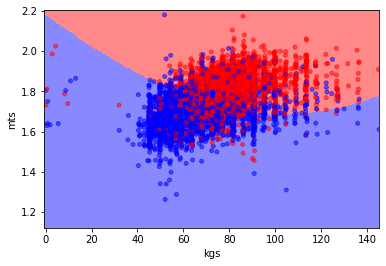

In [42]:
plot_classification(pipaPre, surfaceDF=gridPredictionLRPoly, prob=False)

Fin